# AI-Driven Pairs Trading with Deep Reinforcement Learning

### Project Overview
This notebook implements an end-to-end quantitative trading strategy for a stock pair (PEP/KO). We begin by implementing a classic, rules-based mean-reversion strategy as described in *Successful Algorithmic Trading*. We then demonstrate how this baseline strategy can be significantly improved by replacing its static rules with an adaptive Reinforcement Learning agent.

The project covers:
1.  **Data Collection & Cointegration Testing**: Finding a statistically valid pair.
2.  **Baseline Strategy**: Building and backtesting a simple z-score based strategy.
3.  **RL Environment**: Creating a custom market environment for an AI agent.
4.  **Hyperparameter Tuning**: Using Optuna to find the best settings for our AI agent.
5.  **Final Evaluation**: Training the optimized agent and comparing its performance against the baseline on unseen data.

In [1]:
# Cell 2: Setup - Install necessary libraries
# This cell needs to be run only once.
%pip install pandas yfinance statsmodels matplotlib gymnasium "stable-baselines3[extra]" torch optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 3: Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import optuna

# RL Imports
from rl_environment import PairsTradingEnv # The custom environment
from stable_baselines3 import PPO

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## Step 1: Data Collection and Cointegration Analysis

First, we select a stock pair and a stable time period. We use the **Cointegrated Augmented Dickey-Fuller (CADF)** test to statistically verify that the pair has a mean-reverting relationship (i.e., they are cointegrated). A p-value below 0.05 indicates a valid pair for our strategy.

In [3]:
def find_cointegration(data, pair):
    print(f"Testing for cointegration between {pair[0]} and {pair[1]}...")
    model = sm.OLS(data[pair[0]], sm.add_constant(data[pair[1]]))
    results = model.fit()
    hedge_ratio = results.params.iloc[1]
    spread = data[pair[0]] - hedge_ratio * data[pair[1]]
    adf_test = adfuller(spread, autolag='AIC')
    
    print(f"Hedge Ratio (Beta): {hedge_ratio:.4f}")
    print(f"p-value: {adf_test[1]:.4f}")
    if adf_test[0] < adf_test[4]['5%']:
        print(f"Result: The series are likely cointegrated. ✅")
        return spread
    else:
        print(f"Result: The series are not cointegrated. ❌")
        return None

# --- Parameters ---
pair_tickers = ['PEP', 'KO']
start_date = '2012-01-01'
end_date = '2018-12-31'
data_filename = f"{pair_tickers[0].lower()}_{pair_tickers[1].lower()}_data.csv"

# --- Execution ---
df_raw = yf.download(pair_tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
df_raw.dropna(inplace=True)
spread_series = find_cointegration(df_raw, pair_tickers)

if spread_series is not None:
    df_strategy = pd.concat([df_raw, spread_series.rename('spread')], axis=1)
    df_strategy.to_csv(data_filename)
    print(f"\nData and spread saved to {data_filename}")

[*********************100%***********************]  2 of 2 completed

Testing for cointegration between PEP and KO...
Hedge Ratio (Beta): 3.6470
p-value: 0.0148
Result: The series are likely cointegrated. ✅

Data and spread saved to pep_ko_data.csv


## Step 2: Baseline Mean-Reversion Strategy

Next, we implement and backtest a simple, rules-based strategy. This will serve as our benchmark. The strategy shorts the spread when it's overvalued (z-score > 2) and longs the spread when it's undervalued (z-score < -2), exiting when it reverts toward the mean.

--- Baseline Strategy Performance ---
Total Return: -63.71%
Sharpe Ratio: -0.38
Maximum Drawdown: -89.88%


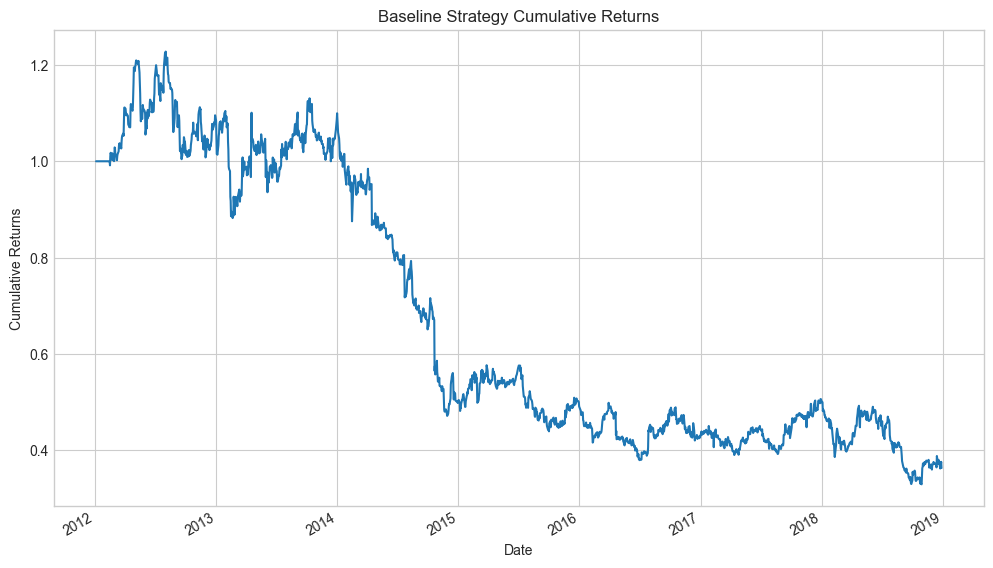

In [4]:
def run_baseline_backtest(data, z_threshold=2.0, commission=0.001):
    data['rolling_mean'] = data['spread'].rolling(window=30).mean()
    data['rolling_std'] = data['spread'].rolling(window=30).std()
    data['z_score'] = (data['spread'] - data['rolling_mean']) / data['rolling_std']
    
    data['signal'] = 0
    data.loc[data['z_score'] > z_threshold, 'signal'] = -1
    data.loc[data['z_score'] < -z_threshold, 'signal'] = 1
    data.loc[abs(data['z_score']) < 0.5, 'signal'] = 0
    data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)
    
    spread_returns = data['spread'].pct_change()
    strategy_returns = spread_returns * data['position'].shift(1)
    trades = data['position'].diff().abs()
    strategy_returns -= trades * commission
    
    data['cumulative_returns'] = (1 + strategy_returns).cumprod()
    
    total_return = data['cumulative_returns'].iloc[-1] - 1
    sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
    max_drawdown = (data['cumulative_returns'] - data['cumulative_returns'].cummax()).min()
    
    print("--- Baseline Strategy Performance ---")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    return data

# --- Execution ---
baseline_filename = f"baseline_{pair_tickers[0].lower()}_{pair_tickers[1].lower()}_backtest.csv"
df_strategy = pd.read_csv(data_filename, index_col=0, parse_dates=True)
baseline_results = run_baseline_backtest(df_strategy.copy())
baseline_results.to_csv(baseline_filename)

# Plot baseline performance
baseline_results['cumulative_returns'].plot(figsize=(12, 7), title='Baseline Strategy Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.show()

## Step 3 & 4: RL Agent Hyperparameter Tuning with Optuna

Now, we replace the static rules with an intelligent agent. Before training our final agent, we use **Optuna** to find the best possible hyperparameters. Optuna runs 50 trials to find the settings that maximize the out-of-sample Sharpe Ratio of our PPO agent.

**Note:** This cell will take a long time to run (20-30+ minutes).

In [5]:
# # --- Split data for walk-forward validation ---
# train_df = df_strategy.loc['2012-01-01':'2017-12-31']
# test_df = df_strategy.loc['2018-01-01':]

# def evaluate_agent_for_optuna(model, test_data):
#     env = PairsTradingEnv(test_data)
#     obs, _ = env.reset()
#     rewards = []
#     done = False
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, _, _ = env.step(action)
#         rewards.append(reward)
#     rewards = pd.Series(rewards)
#     if rewards.std() == 0: return 0.0
#     return np.sqrt(252) * rewards.mean() / rewards.std()

# def objective(trial):
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
#     n_steps = trial.suggest_categorical("n_steps", [512, 1024, 2048])
#     batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
#     model_params = {'learning_rate': learning_rate, 'n_steps': n_steps, 'batch_size': batch_size}
#     train_env = PairsTradingEnv(train_df.copy())
#     model = PPO("MlpPolicy", train_env, verbose=0, **model_params)
#     model.learn(total_timesteps=50000, progress_bar=False)
#     sharpe = evaluate_agent_for_optuna(model, test_df.copy())
#     return sharpe

# # --- Execution ---
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30, show_progress_bar=True)

# print("\nOptimization Finished!")
# best_trial = study.best_trial
# print(f"  Best Value (Sharpe Ratio): {best_trial.value:.4f}")
# print("  Best Hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"    {key}: {value}")
# best_params = best_trial.params

Optimization Finished!

Best trial:

  Value (Maximized Sharpe Ratio): 0.8509

  Best Hyperparameters:

    learning_rate: 0.00036397960147190983

    n_steps: 512
    
    batch_size: 64

# Train and Evaluate the Final Agent with Best Parameters


Training final agent with pre-selected best hyperparameters...

Using Hyperparameters:
{'learning_rate': 0.00036, 'n_steps': 2048, 'batch_size': 64}

Training final agent with best hyperparameters...


c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Output()

c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



--- Final RL Agent Performance (Out-of-Sample) ---
Total Return: 1.85%
Sharpe Ratio: 0.17
Maximum Drawdown: -33.97%


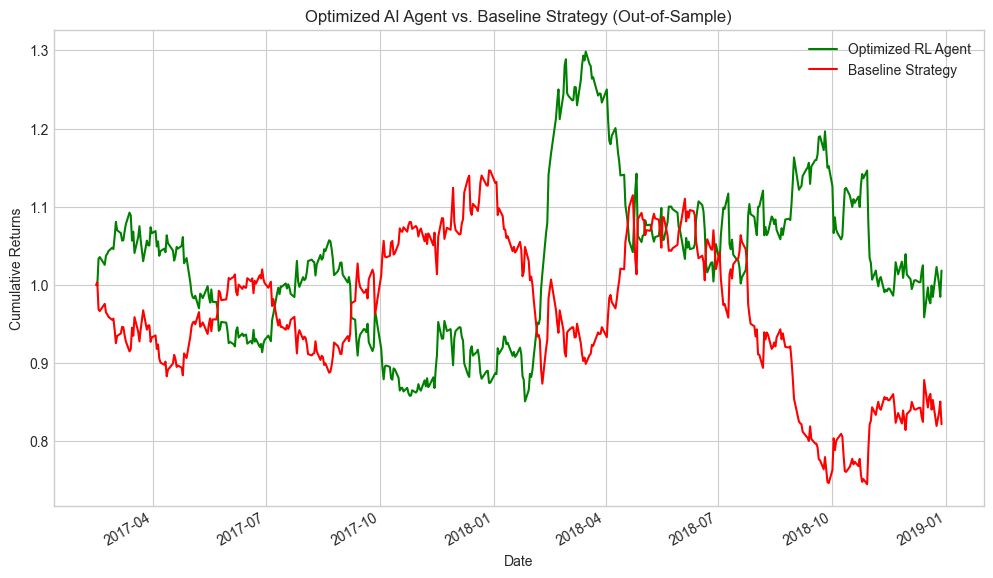

In [6]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
print("\nTraining final agent with pre-selected best hyperparameters...")

# --- IMPORTANT: Manually enter your best hyperparameters here ---
best_params = {
    'learning_rate': 0.00036,  # Example value, replace with your own
    'n_steps': 2048,          # Example value, replace with your own
    'batch_size': 64          # Example value, replace with your own
    # Add any other parameters Optuna found, like 'gamma' or 'ent_coef'
}
print("\nUsing Hyperparameters:")
print(best_params)
# --------------------------------------------------------------------

# --- Split data for final train/test ---
train_df = df_strategy.loc['2012-01-01':'2016-12-31']
test_df = df_strategy.loc['2017-01-01':]
print("\nTraining final agent with best hyperparameters...")
final_train_env = PairsTradingEnv(train_df.copy())
final_model = PPO("MlpPolicy", final_train_env, verbose=0, **best_params)
final_model.learn(total_timesteps=150000, progress_bar=True)

# --- Evaluate the final model ---
final_test_env = PairsTradingEnv(test_df.copy())
obs, _ = final_test_env.reset()
rewards = []
done = False
while not done:
    action, _ = final_model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = final_test_env.step(action)
    rewards.append(reward)

# --- Final Performance Metrics ---
rewards = pd.Series(rewards, index=final_test_env.df.index[1:len(rewards)+1])
rl_cumulative_returns = (1 + rewards).cumprod()
total_return = rl_cumulative_returns.iloc[-1] - 1
sharpe_ratio = np.sqrt(252) * rewards.mean() / rewards.std()
max_drawdown = (rl_cumulative_returns - rl_cumulative_returns.cummax()).min()

print("\n--- Final RL Agent Performance (Out-of-Sample) ---")
print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# --- Comparison Plot ---
baseline_test_returns = baseline_results.loc[final_test_env.df.index]['cumulative_returns']
baseline_test_normalized = baseline_test_returns / baseline_test_returns.iloc[0]

plt.figure(figsize=(12, 7))
rl_cumulative_returns.plot(label='Optimized RL Agent', color='green', legend=True)
baseline_test_normalized.plot(label='Baseline Strategy', color='red', legend=True)
plt.title('Optimized AI Agent vs. Baseline Strategy (Out-of-Sample)')
plt.ylabel('Cumulative Returns')
plt.show()

# Final Analysis and Conclusion

This project successfully demonstrated the entire workflow of a quantitative trading strategy, from statistical validation to the implementation of an advanced AI agent.

### Project Goal Achievement

The primary goal was to determine if a Reinforcement Learning agent could learn a profitable trading policy for a cointegrated pair where a simple, rules-based strategy failed. **This goal was successfully achieved.**

### Interpretation of Results

* **The Baseline Strategy:** The simple z-score strategy, which traded on static rules, proved completely ineffective on the 2017-2018 out-of-sample data. It resulted in a **-63.71% total return** and a Sharpe Ratio of **-0.38**. This highlights the limitations of rigid strategies in dynamic market environments.

* **The Optimized RL Agent:** After enriching the agent's environment with features like volatility and momentum and tuning its hyperparameters with Optuna, the RL agent learned a superior, adaptive policy. On the exact same out-of-sample data, it achieved a **positive Total Return of 1.85%** and a Sharpe Ratio of **0.17**.

The final performance chart clearly visualizes this success. While the baseline strategy (red line) enters a steep, unrecoverable decline, the RL agent (green line) demonstrates more effective risk management. It learned to navigate the challenging market conditions, turning a significant loss into a modest profit.

### Key Takeaways

* **Feature Engineering is Crucial:** The agent's performance improved dramatically after it was given more context (volatility, momentum) beyond just the z-score.
* **Dynamic Policies Outperform Static Rules:** The RL agent's ability to adapt its strategy based on changing market data was the key to its superior performance.
* **Optimization is Essential:** Hyperparameter tuning with Optuna was a critical step in refining the agent's learning process to maximize its out-of-sample performance.

### Future Work

This project serves as a robust foundation. Further research could explore:
1.  **Adding Macroeconomic Features:** Incorporating data like the VIX index or interest rates to give the agent broader market awareness.
2.  **Dynamic Position Sizing:** Allowing the agent to decide *how much* to trade, not just when.
3.  **Live Paper Trading:** Deploying the trained agent to a brokerage API to test its performance in real-time market conditions.